In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

import metpy

import itertools
import time
import sys  

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics

from soundings.preprocessing import dataloader as dl

from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Wed Nov  4 22:07:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   30C    P8    12W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

In [4]:
f = '/mnt/data1/stock/mlsoundings/preprocessed.npz'
# np.savez(f, raob=raob, rap=rap,
#          goes=goes, rtma=rtma, sonde_files=sonde_files)

container = np.load(f)

print(container.files)

raob = container['raob']
rap = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']

print(raob.shape, rap.shape, goes.shape, rtma.shape)

['raob', 'rap', 'goes', 'rtma', 'sonde_files']
(81276, 256, 4) (81276, 256, 4) (81276, 3, 3, 8) (81276, 3, 3, 3)


In [4]:
diff = raob[:,:,dl.TEMPERATURE] - rap[:,:,dl.TEMPERATURE]

threshold = 20
inds = np.unique(np.where(abs(diff) >= threshold)[0])

raob = np.delete(raob, inds, 0)
rap  = np.delete(rap, inds, 0)
goes = np.delete(goes, inds, 0)
rtma = np.delete(rtma, inds, 0)
sonde_files = np.delete(sonde_files, inds, 0)

In [5]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT, dl.ALTITUDE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, [dl.TEMPERATURE, dl.DEWPOINT]]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, [dl.TEMPERATURE, dl.DEWPOINT]]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((65021, 256, 4), (65021, 256, 2), (16255, 256, 4), (16255, 256, 2))

In [6]:
nnet = nn.SkipNeuralNetwork(Xtrain.shape[1:], [64, 128, 256], 
                            [(3, 1), (3, 1), (3, 1)],
                            Ttrain.shape[1:])
# nnet.model.summary()
# nnet.train(Xtrain, Ttrain, 30, 128, method='adam', verbose=True,
#            learning_rate=0.0001, validation=[Xtest, Ttest])

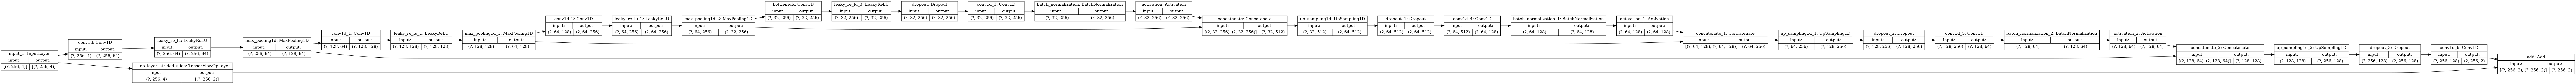

In [9]:
tf.keras.utils.plot_model(nnet.model , '/home/stock/research/media/multi_output_unet.png',
                          show_shapes=True, rankdir='LR', dpi=96) # LR/TB positioning

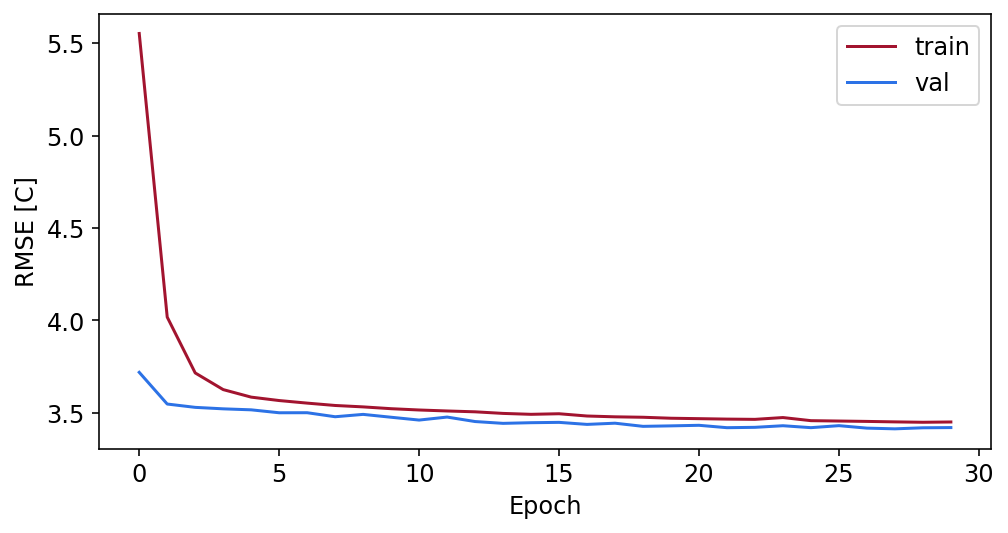

In [88]:
results.plot_loss(nnet)

In [89]:
Y = nnet.use(Xtest)

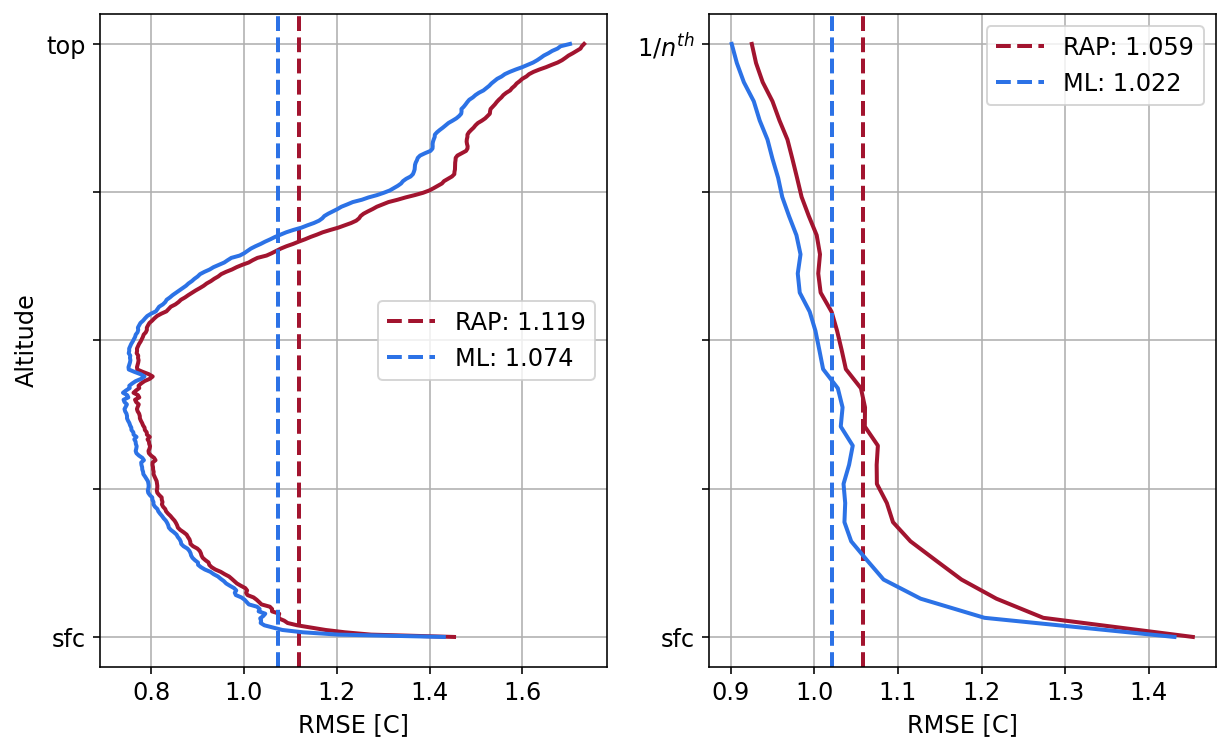

In [90]:
# 1.055, 0.995 (8,1)
results.plot_altitude_rmse_verticle(None, None, Ttest[:,:,0],
                                    Xtest[:,:,dl.TEMPERATURE], Y=Y[:,:,0])

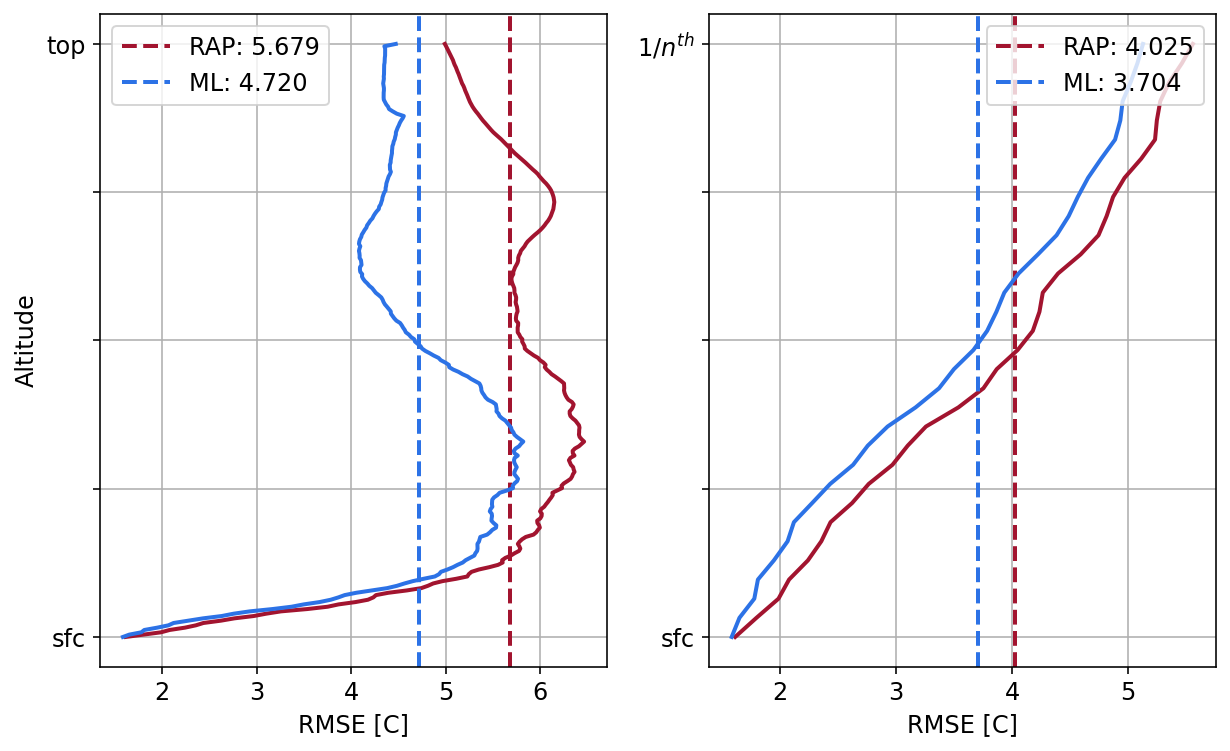

In [91]:
# 4.549, 3.590 (8,1)
results.plot_altitude_rmse_verticle(None, None, Ttest[:,:,1],
                                    Xtest[:,:,dl.DEWPOINT], Y=Y[:,:,1])

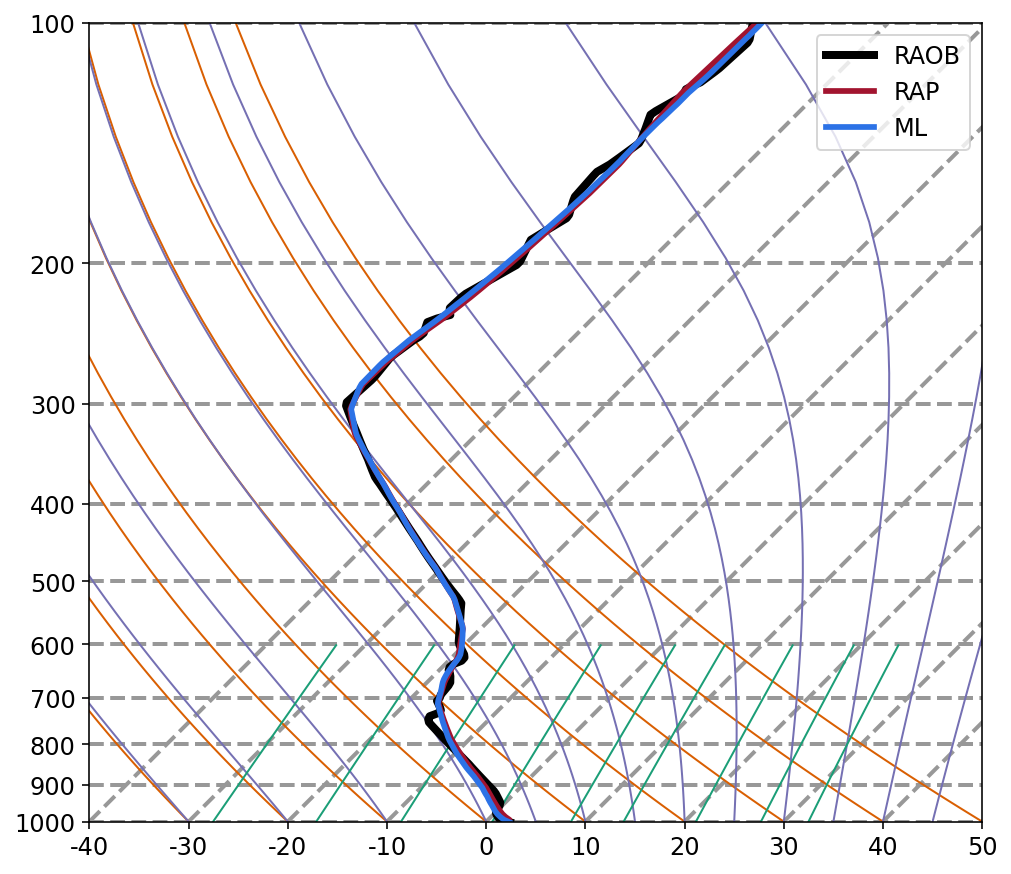

In [28]:
i = 11
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i,:,0]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = Y[i,:,0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

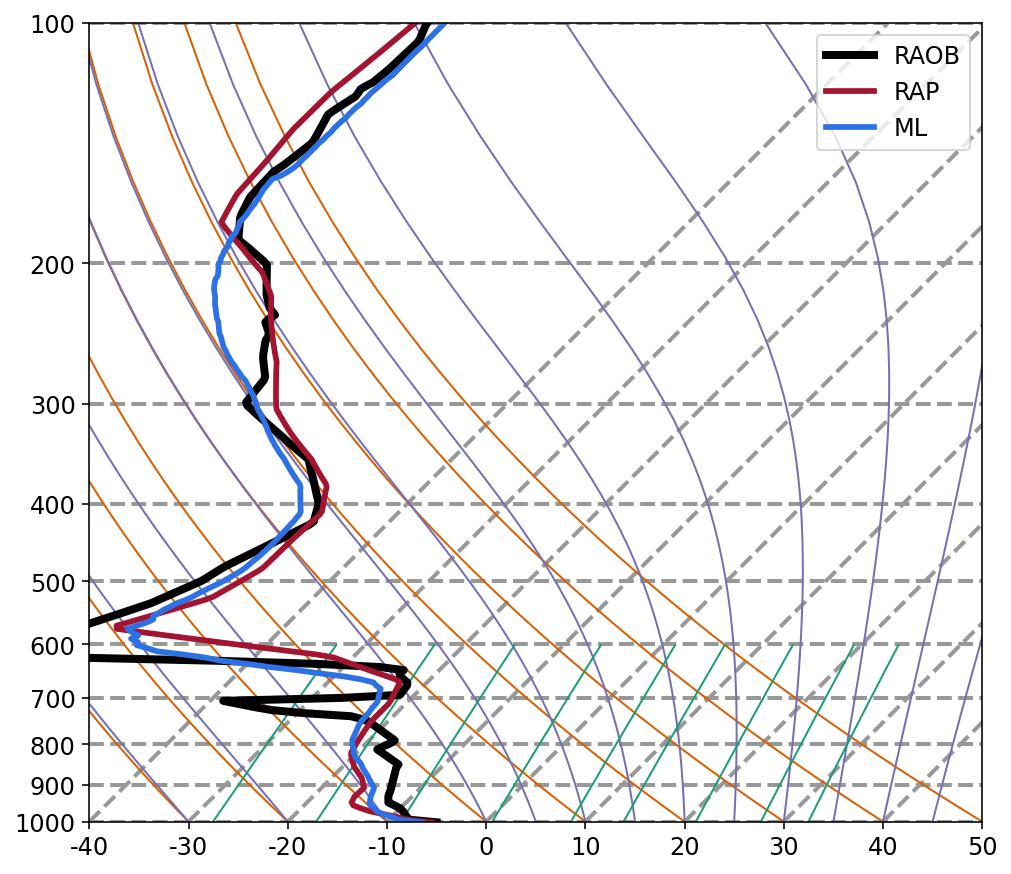

In [29]:
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i,:,1]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.DEWPOINT]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = Y[i,:,1]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [51]:
pressure = Xtrain[i, :, dl.PRESSURE] * metpy.units.units.hPa
temperature = Xtrain[i, :, dl.TEMPERATURE] * metpy.units.units.degC
dewpoint = Xtrain[i, :, dl.DEWPOINT] * metpy.units.units.degC

cape, cin = metpy.calc.surface_based_cape_cin(pressure, temperature, dewpoint)
cape, cin

(11.554822779356062 <Unit('joule / kilogram')>, 0.0 <Unit('joule / kilogram')>)

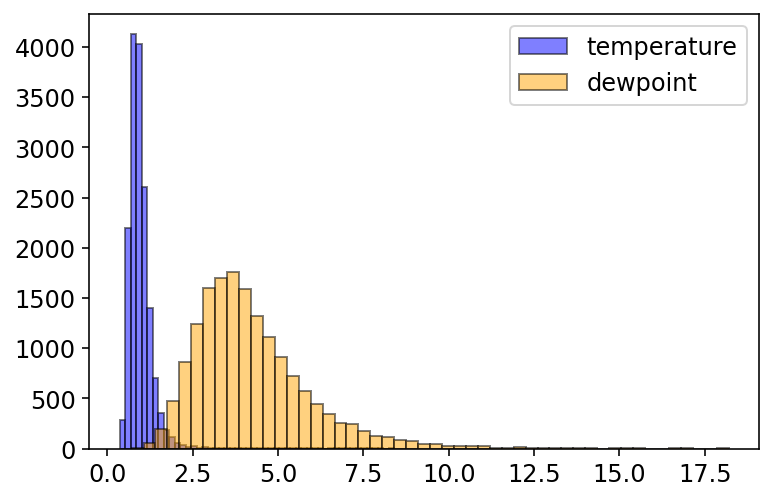

In [58]:
Y = nnet.use(Xtest)
error = np.sqrt(np.mean((Y - Ttest)**2, axis = 1))

plt.hist(error[:,0], color='blue', edgecolor='black',
         alpha=0.5, bins=50, label='temperature')
plt.hist(error[:,1], color='orange', edgecolor='black',
         alpha=0.5, bins=50, label='dewpoint')
plt.legend(); 

In [63]:
nnet = nn.SkipNeuralNetwork(Xtrain.shape[1:], [256, 512, 1024], 
                            [(5, 1), (5, 1), (5, 1)],
                            Ttrain.shape[1:])
nnet.model.summary()

(None, 256, 2)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 256)     5376        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 128, 256)     0           leaky_re_lu[0][0]                
________________________________________________________________________

In [49]:
df = pd.read_csv('/mnt/data1/stock/mlsoundings/results/linear_model_temperature_dewpoint.csv')

In [50]:
from ast import literal_eval

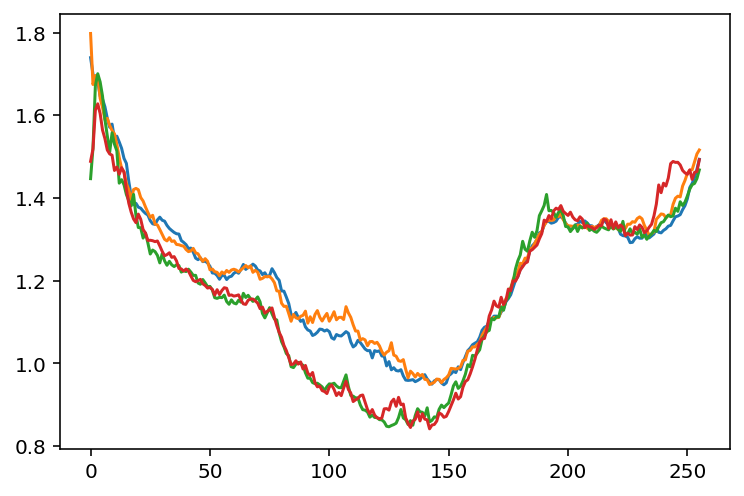

In [63]:
for i in range(len(df)):
    r = df.iloc[i]
    plt.plot(np.array(literal_eval(r['ml_temperature_test_rmse'])))
#     plt.plot(np.array(literal_eval(r['ml_dewpoint_test_rmse'])))

In [53]:
df.keys()

Index(['rap_input_dims', 'rap_output_dims', 'rtma_input_channels',
       'goes_input_channels', 'n_network_inputs', 'hiddens',
       'n_network_outputs', 'optim', 'lr', 'activ', 'loss', 'n_epochs',
       'batch_size', 'batchnorm', 'dropout', 'root_mean_squared_error',
       'mean_squared_error', 'mean_absolute_error', 'val_loss',
       'val_root_mean_squared_error', 'val_mean_squared_error',
       'val_mean_absolute_error', 'ml_temperature_train_rmse',
       'ml_temperature_train_mean_rmse', 'ml_temperature_train_rmse_sfc',
       'ml_temperature_train_mean_rmse_sfc', 'ml_dewpoint_train_rmse',
       'ml_dewpoint_train_mean_rmse', 'ml_dewpoint_train_rmse_sfc',
       'ml_dewpoint_train_mean_rmse_sfc', 'ml_temperature_val_rmse',
       'ml_temperature_val_mean_rmse', 'ml_temperature_val_rmse_sfc',
       'ml_temperature_val_mean_rmse_sfc', 'ml_dewpoint_val_rmse',
       'ml_dewpoint_val_mean_rmse', 'ml_dewpoint_val_rmse_sfc',
       'ml_dewpoint_val_mean_rmse_sfc', 'ml_test_cape'

In [56]:
df['ml_test_cape'][0], df['ml_test_cin'][0]

('[0.0, 0.0, 0.0, 0.0, 5.001096059985844, 7.688338894812549, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, -25.55891230947458, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]')